# HLOC NetVLAD Testing

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Check if we have NVidia Driver installed !
!nvidia-smi

Sun Aug  4 18:55:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:41:00.0 Off |                  N/A |
| 39%   61C    P2            155W /  420W |    1594MiB /  24576MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Import Stuff

In [3]:
# Imports
# Date Time
from dateutil import tz
from datetime import datetime

# Libraries
import sys
import os
import copy
import json
import numpy as np
import shutil
import PIL

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets, metrics

# PYTORCH !
import torch
import torchinfo
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Visualization
# %matplotlib widget
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from torch.utils.tensorboard import SummaryWriter

# Path for Import Internal Modules
sys.path.append("/workspace/fisheye-vpr")


2024-08-04 18:55:13.116097: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 18:55:13.964298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Fix Seed for Reproducablity

In [4]:
# Fixxxing the Seed !
torch.manual_seed(666)

---

## Import Model

In [5]:
# Main Model
from models.vpr_model import VPRModel

# Feature Extractor
from models.encoders.hloc_vgg16 import HLOCVGG16Encoder

# Clustering
from models.clustering.hloc_netvlad import HLOCNetVLAD

# Loss
from models.loss_function.HardTripletLoss import HardTripletLoss

# Trainer
from util.train import Trainer

---

## Dataset Selection

In [6]:
# Import Dataset Class
from dataloaders.eng3_floor1_fisheye import ENG3_Floor1_Fisheye_Dataset

# Create Dataset Instance
dataset = ENG3_Floor1_Fisheye_Dataset()

---

##  Dataset Exploring

In [7]:
import util.notebook_util as notebook_util

(2, 2)


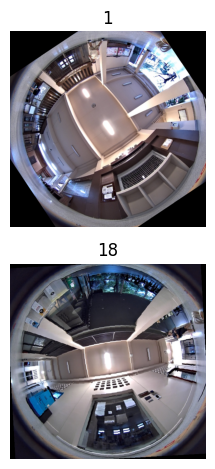

In [8]:
# Display the output
train_batch = next(iter(dataset.train_dataloader))
train_class = dataset.dataset.classes
notebook_util.visualize_batch(train_batch, train_class, header="train batch")

In [9]:
# Reload Dataset to have all the iterator reset
dataset = ENG3_Floor1_Fisheye_Dataset()

---

## Model Assembling

In [10]:
# Feature Extractor
from models.encoders.hloc_vgg16 import HLOCVGG16Encoder
# Create the Encoder
encoder = HLOCVGG16Encoder()


[HLOC-VGG16] Loading Pretrained Model
[HLOC-VGG16] MATLAB Weights :  /workspace/fisheye-vpr/models/weights/Pitts30K_struct.mat
[HLOCVGG16] CONV2D in Layer 0 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 2 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 5 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 7 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 10 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 12 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 14 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 17 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 19 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 21 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 24 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 26 Weights and Bias Imported
[HLOCVGG16] CONV2D in Layer 28 Weights and Bias Imported
[HLOC-VGG16] Output Dim Size: 512


In [11]:
# Clustering
from models.clustering.hloc_netvlad import HLOCNetVLAD
netvlad_config = {
    "num_clusters": 64,
    "desc_dim": 512,            # Up to the Feature Extraction Module
}
clustering = HLOCNetVLAD(**netvlad_config)

[HLOC-NetVLAD] Initializing NetVLAD Layer
[HLOC-NetVLAD] Input Dimension :  512
[HLOC-NetVLAD] Number of Clusters :  64
[HLOC-NetVLAD] Score Bias :  False
[HLOC-NetVLAD] Intra Normalization :  True
[HLOC-NetVLAD] Whiten :  True
Loading MATLAB Weights based on path :  /workspace/fisheye-vpr/models/weights/Pitts30K_struct.mat
[HLOC-NetVLAD] Weights Imported


In [12]:
model = VPRModel(
    feature_extractor=encoder,
    clustering=clustering
)
model = model.to("cuda")


In [13]:
torchinfo.summary(model, input_size=(1,3,256,256))


[HLOC-NetVLAD] Flattened Input Shape :  torch.Size([1, 512, 256])


Layer (type:depth-idx)                   Output Shape              Param #
VPRModel                                 [1, 4096]                 --
├─HLOCVGG16Encoder: 1-1                  [1, 512, 16, 16]          --
│    └─Sequential: 2-1                   [1, 512, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         1,792
│    │    └─ReLU: 3-2                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-3                  [1, 64, 256, 256]         36,928
│    │    └─ReLU: 3-4                    [1, 64, 256, 256]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-6                  [1, 128, 128, 128]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 128, 128]        --
│    │    └─Conv2d: 3-8                  [1, 128, 128, 128]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 128, 128]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 64, 64]          --